# Adventures with Autodiff

# GPU

This lecture was built using a machine with JAX installed and access to a GPU.

To run this lecture on [Google Colab](https://colab.research.google.com/), click on the “play” icon top right, select Colab, and set the runtime environment to include a GPU.

To run this lecture on your own machine, you need to install [Google JAX](https://github.com/google/jax).

## Overview

This lecture gives a brief introduction to automatic differentiation using
Google JAX.

Automatic differentiation is one of the key elements of modern machine learning
and artificial intelligence.

As such it has attracted a great deal of investment and there are several
powerful implementations available.

One of the best of these is the automatic differentiation routines contained
in JAX.

While other software packages also offer this feature, the JAX version is
particularly powerful because it integrates so well with other core
components of JAX (e.g., JIT compilation and parallelization).

As we will see in later lectures, automatic differentiation can be used not only
for AI but also for many problems faced in mathematical modeling, such as
multi-dimensional nonlinear optimization and root-finding problems.

We need the following imports

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

Checking for a GPU:

In [2]:
!nvidia-smi

Mon Mar  3 13:40:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## What is automatic differentiation?

Autodiff is a technique for calculating derivatives on a computer.

### Autodiff is not finite differences

The derivative of $ f(x) = \exp(2x) $ is

$$
f'(x) = 2 \exp(2x)
$$

A computer that doesn’t know how to take derivatives might approximate this with the finite difference ratio

$$
(Df)(x) := \frac{f(x+h) - f(x)}{h}
$$

where $ h $ is a small positive number.

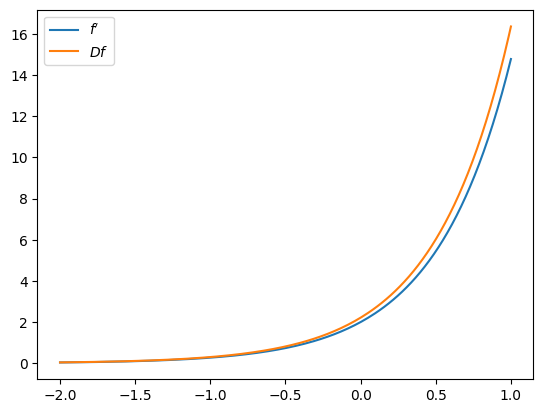

In [3]:
def f(x):
    "Original function."
    return np.exp(2 * x)

def f_prime(x):
    "True derivative."
    return 2 * np.exp(2 * x)

def Df(x, h=0.1):
    "Approximate derivative (finite difference)."
    return (f(x + h) - f(x))/h

x_grid = np.linspace(-2, 1, 200)
fig, ax = plt.subplots()
ax.plot(x_grid, f_prime(x_grid), label="$f'$")
ax.plot(x_grid, Df(x_grid), label="$Df$")
ax.legend()
plt.show()

This kind of numerical derivative is often inaccurate and unstable.

One reason is that

$$
\frac{f(x+h) - f(x)}{h} \approx \frac{0}{0}
$$

Small numbers in the numerator and denominator causes rounding errors.

The situation is exponentially worse in high dimensions / with higher order derivatives

### Autodiff is not symbolic calculus

Symbolic calculus tries to use rules for differentiation to produce a single
closed-form expression representing a derivative.

In [ ]:
from sympy import symbols, diff

m, a, b, x = symbols('m a b x')
f_x = (a*x + b)**m
f_x.diff((x, 6))  # 6-th order derivative

Symbolic calculus is not well suited to high performance
computing.

One disadvantage is that symbolic calculus cannot differentiate through control flow.

Also, using symbolic calculus might involve redundant calculations.

For example, consider

$$
(f g h)'
    = (f' g + g' f) h + (f g) h'
$$

If we evaluate at $ x $, then we evalute $ f(x) $ and $ g(x) $ twice each.

Also, computing $ f'(x) $ and $ f(x) $ might involve similar terms (e.g., $ (f(x) = \exp(2x)' \implies f'(x) = 2f(x) $) but this is not exploited in symbolic algebra.

 符号微分（Symbolic Calculus）

符号微分使用代数规则来解析求导，并直接给出一个**封闭形式（closed-form expression）**的导数结果。

这段代码会直接输出 f_x 对 x 求 6 阶导数的解析表达式。

缺点：

- 计算成本高：符号微分不适用于高性能计算，比如大规模的机器学习任务。
- 无法处理控制流（control flow）：比如 if 语句或循环结构，符号微分难以解析这些动态计算路径。
- 可能导致冗余计算：例如计算(fgh)'时，f(x) 和g(x) 可能会被重复计算两次。

### Autodiff

Autodiff produces functions that evaluates derivatives at numerical values
passed in by the calling code, rather than producing a single symbolic
expression representing the entire derivative.

Derivatives are constructed by breaking calculations into component parts via the chain rule.

The chain rule is applied until the point where the terms reduce to primitive functions that the program knows how to differentiate exactly (addition, subtraction, exponentiation, sine and cosine, etc.)

自动微分采用数值计算的方式，不会生成封闭解析表达式，而是在计算过程中记录数值计算的轨迹，然后通过链式法则高效地计算梯度。

优点：

- 计算效率高：避免了符号微分的解析展开，适用于大规模计算。
- 支持控制流：jax 的 autodiff 可以处理 if 语句和循环。
- 避免冗余计算：例如计算 (fgh)' 时，autodiff 只会计算 f(x)、g(x) 一次，然后利用链式法则。

## Some experiments

Let’s start with some real-valued functions on $ \mathbb R $.

### A differentiable function

Let’s test JAX’s auto diff with a relatively simple function.

In [4]:
def f(x):
    return jnp.sin(x) - 2 * jnp.cos(3 * x) * jnp.exp(- x**2)

We use `grad` to compute the gradient of a real-valued function:

In [5]:
f_prime = jax.grad(f)

In [8]:
print(f_prime)

<function f at 0x791dac58d120>


Let’s plot the result:

In [6]:
x_grid = jnp.linspace(-5, 5, 100)

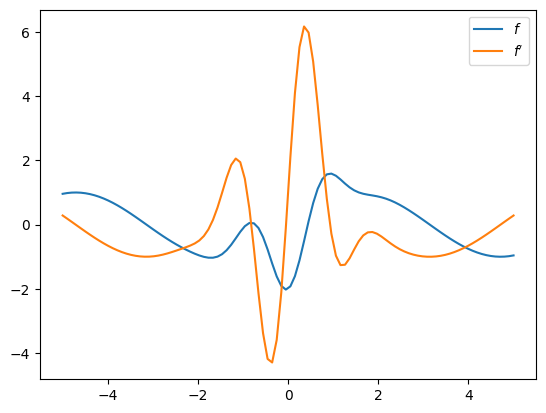

In [7]:
fig, ax = plt.subplots()
ax.plot(x_grid, [f(x) for x in x_grid], label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend()
plt.show()

### Absolute value function

What happens if the function is not differentiable?

In [9]:
def f(x):
    return jnp.abs(x)

In [10]:
f_prime = jax.grad(f)

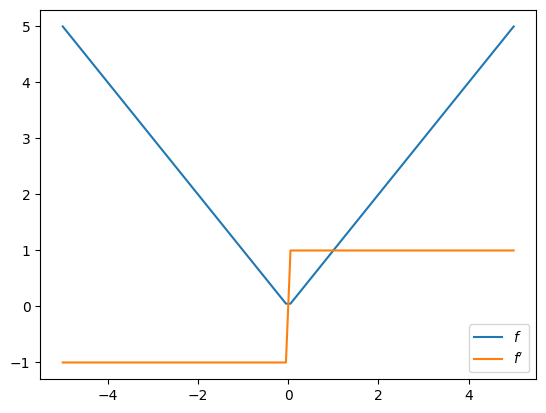

In [11]:
fig, ax = plt.subplots()
ax.plot(x_grid, [f(x) for x in x_grid], label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend()
plt.show()

At the nondifferentiable point $ 0 $, `jax.grad` returns the right derivative:

In [12]:
f_prime(0.0)

Array(1., dtype=float32, weak_type=True)

### Differentiating through control flow

Let’s try differentiating through some loops and conditions.

控制流指的是代码执行时遇到的条件判断（if-else）、循环（for, while）或递归等动态逻辑。例如：

if-else 根据条件执行不同的代码块。
for 循环遍历一系列值，执行相应操作。
while 直到条件满足才终止循环。

JAX 的自动微分可以正确处理控制流，这使得它比传统的符号微分（如 sympy）更适合程序化计算，特别是在机器学习和优化任务中。



In [13]:
def f(x):
    def f1(x):
        for i in range(2):
            x *= 0.2 * x
        return x
    def f2(x):
        x = sum((x**i + i) for i in range(3))
        return x
    y = f1(x) if x < 0 else f2(x)
    return y

In [14]:
f_prime = jax.grad(f)

In [15]:
x_grid = jnp.linspace(-5, 5, 100)

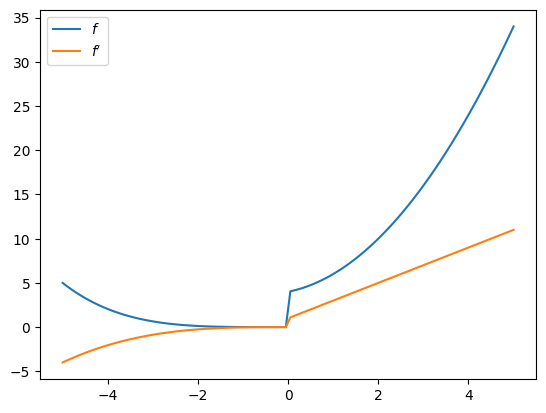

In [16]:
fig, ax = plt.subplots()
ax.plot(x_grid, [f(x) for x in x_grid], label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend()
plt.show()

### Differentiating through a linear interpolation

We can differentiate through linear interpolation, even though the function is not smooth:

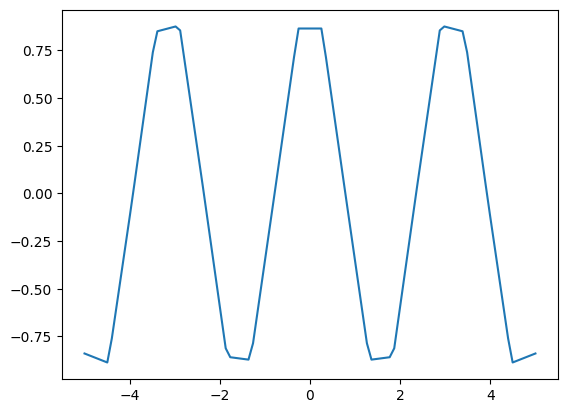

In [17]:
n = 20
xp = jnp.linspace(-5, 5, n)
yp = jnp.cos(2 * xp)

fig, ax = plt.subplots()
ax.plot(x_grid, jnp.interp(x_grid, xp, yp))
plt.show()

In [19]:
print(yp)

[-0.8390716  -0.88818824 -0.04074433  0.84782827  0.8805797   0.02445074
 -0.85635984 -0.8727376  -0.00815065  0.8646638   0.8646638  -0.00815113
 -0.8727378  -0.8563597   0.02445121  0.88058037  0.84782803 -0.04074385
 -0.88818824 -0.8390716 ]


n = 20：创建 20 个插值点。

xp = jnp.linspace(-5, 5, n)：在 [-5, 5] 之间生成 20 个均匀分布的 x 值，作为插值点的 x 轴坐标。

yp = jnp.cos(2 * xp)：计算 xp 处的 cos(2x)，作为 y 值，即插值点的 y 轴坐标。

jnp.interp(x_grid, xp, yp)：对 x_grid 进行线性插值，即用 xp 和 yp 生成的折线来估算 x_grid 处的 y 值。

ax.plot(x_grid, jnp.interp(x_grid, xp, yp))：绘制插值后的曲线。

In [20]:
f_prime = jax.grad(jnp.interp)

jax.grad(jnp.interp) 试图计算 jnp.interp() 的梯度。

问题：jnp.interp() 本质上是分段线性函数，梯度在每个插值点之间是恒定的，但在插值点处不连续。

JAX 仍然可以计算梯度，但结果可能不光滑。

In [21]:
f_prime_vec = jax.vmap(f_prime, in_axes=(0, None, None))

jax.vmap() 使 f_prime 适用于 x_grid 的所有点：
- in_axes=(0, None, None)：
- 0 表示对 x_grid 逐元素计算梯度。
- None 表示 xp 和 yp 作为常量，不变化。


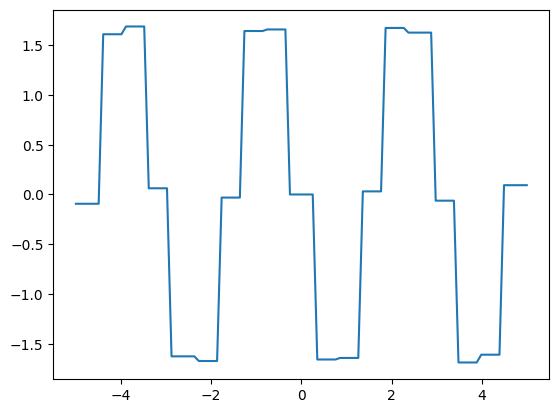

In [22]:
fig, ax = plt.subplots()
ax.plot(x_grid, f_prime_vec(x_grid, xp, yp))
plt.show()

## Gradient Descent

Let’s try implementing gradient descent.

As a simple application, we’ll use gradient descent to solve for the OLS parameter estimates in simple linear regression.

### A function for gradient descent

Here’s an implementation of gradient descent.

这段代码实现了 梯度下降算法（Gradient Descent），用于最小化一个函数 f。它采用 Barzilai-Borwein（BB）方法 计算学习率 λ（自适应学习率，类似于Hessian Matrix），并在满足收敛条件后停止优化。

In [7]:
def grad_descent(f,       # Function to be minimized
                 args,    # Extra arguments to the function
                 x0,      # Initial condition
                 λ=0.1,   # Initial learning rate
                 tol=1e-5,
                 max_iter=1_000):
    """
    Minimize the function f via gradient descent, starting from guess x0.

    The learning rate is computed according to the Barzilai-Borwein method.

    """

    f_grad = jax.grad(f)  # 计算 f(x) 的梯度函数
    x = jnp.array(x0)
    df = f_grad(x, args)  # 计算初始点 x0 的梯度
    ϵ = tol + 1 # 初始化误差 ϵ = tol + 1，确保 while 循环能够执行至少一次。
    i = 0
    while ϵ > tol and i < max_iter:
        new_x = x - λ * df  # 梯度下降更新 x
        new_df = f_grad(new_x, args)  # 计算新点的梯度
        Δx = new_x - x
        Δdf = new_df - df
        λ = jnp.abs(Δx @ Δdf) / (Δdf @ Δdf) # BB 方法计算新的学习率
        ϵ = jnp.max(jnp.abs(Δx)) # 误差 ϵ 表示 x 变化的最大值，用于判断是否收敛。
        x, df = new_x, new_df
        i += 1

    return x

### Simulated data

We’re going to test our gradient descent function my minimizing a sum of least squares in a regression problem.

Let’s generate some simulated data:

In [5]:
n = 100
key = jax.random.PRNGKey(1234)
x = jax.random.uniform(key, (n,))

α, β, σ = 0.5, 1.0, 0.1  # Set the true intercept and slope.
key, subkey = jax.random.split(key)
ϵ = jax.random.normal(subkey, (n,))

y = α * x + β + σ * ϵ

生成
x（自变量），随机均匀分布在
[0,1] 之间。

生成
y（因变量），服从 线性关系.


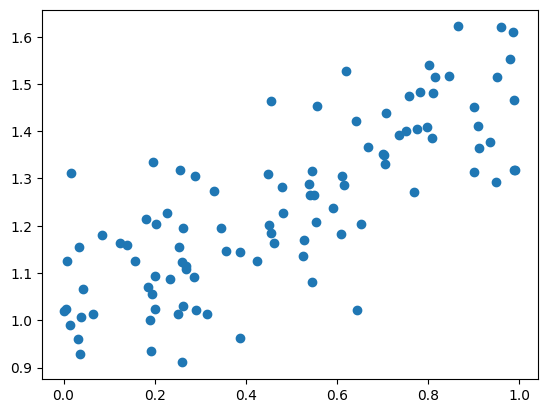

In [25]:
fig, ax = plt.subplots()
ax.scatter(x, y)
plt.show()

Let’s start by calculating the estimated slope and intercept using closed form solutions.

In [26]:
mx = x.mean()
my = y.mean()
α_hat = jnp.sum((x - mx) * (y - my)) / jnp.sum((x - mx)**2)
β_hat = my - α_hat * mx

In [27]:
α_hat, β_hat

(Array(0.45994443, dtype=float32), Array(1.0219053, dtype=float32))

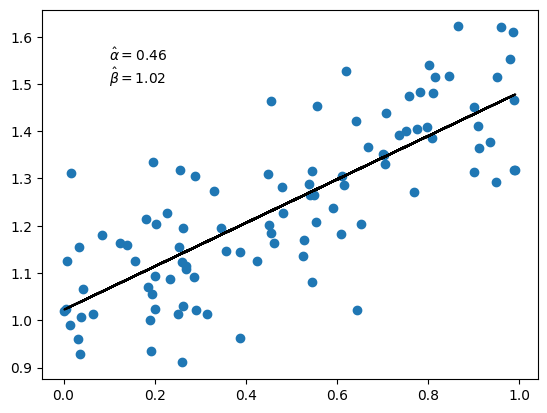

In [28]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, α_hat * x + β_hat, 'k-')
ax.text(0.1, 1.55, rf'$\hat \alpha = {α_hat:.3}$')
ax.text(0.1, 1.50, rf'$\hat \beta = {β_hat:.3}$')
plt.show()

### Minimizing squared loss by gradient descent

Let’s see if we can get the same values with our gradient descent function.

First we set up the least squares loss function.

In [3]:
@jax.jit
def loss(params, data):
    a, b = params
    x, y = data
    return jnp.sum((y - a * x - b)**2)

Now we minimize it:

In [8]:
p0 = jnp.zeros(2)  # Initial guess for α, β
data = x, y # 数据集
α_hat, β_hat = grad_descent(loss, data, p0)

p0 = jnp.zeros(2)：
α 和 β 的初始值为 0（随机初始化）。

grad_descent(loss, data, p0)：
调用 grad_descent() 执行梯度下降。

目标：最小化 loss(params, data)。

Let’s plot the results.

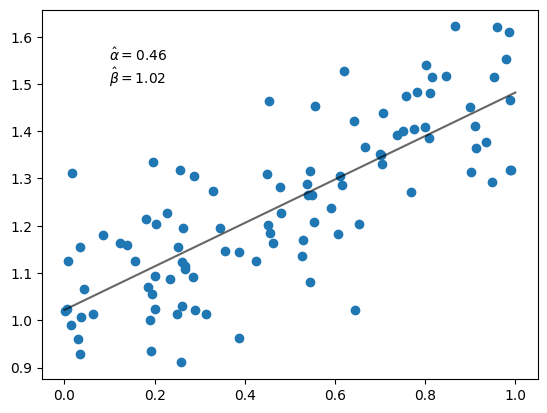

In [9]:
fig, ax = plt.subplots()
x_grid = jnp.linspace(0, 1, 100)
ax.scatter(x, y)
ax.plot(x_grid, α_hat * x_grid + β_hat, 'k-', alpha=0.6)
ax.text(0.1, 1.55, rf'$\hat \alpha = {α_hat:.3}$')
ax.text(0.1, 1.50, rf'$\hat \beta = {β_hat:.3}$')
plt.show()

Notice that we get the same estimates as we did from the closed form solutions.

### Adding a squared term

Now let’s try fitting a second order polynomial.

Here’s our new loss function.

In [10]:
@jax.jit
def loss(params, data):
    a, b, c = params
    x, y = data
    return jnp.sum((y - a * x**2 - b * x - c)**2)

Now we’re minimizing in three dimensions.

Let’s try it.

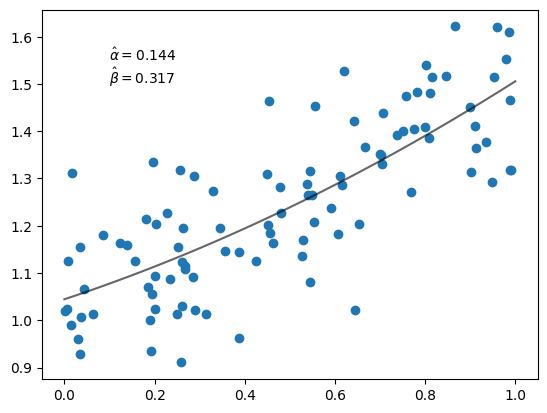

In [11]:
p0 = jnp.zeros(3)
α_hat, β_hat, γ_hat = grad_descent(loss, data, p0)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x_grid, α_hat * x_grid**2 + β_hat * x_grid + γ_hat, 'k-', alpha=0.6)
ax.text(0.1, 1.55, rf'$\hat \alpha = {α_hat:.3}$')
ax.text(0.1, 1.50, rf'$\hat \beta = {β_hat:.3}$')
plt.show()

## Exercises

## Exercise 3.1

The function `jnp.polyval` evaluates polynomials.

For example, if `len(p)` is 3, then `jnp.polyval(p, x)`  returns

$$
f(p, x) := p_0 x^2 + p_1 x + p_2
$$

Use this function for polynomial regression.

The (empirical) loss becomes

$$
\ell(p, x, y)
    = \sum_{i=1}^n (y_i - f(p, x_i))^2
$$

Set $ k=4 $ and set the initial guess of `params` to `jnp.zeros(k)`.

Use gradient descent to find the array `params` that minimizes the loss
function and plot the result (following the examples above).

In [12]:
@jax.jit
def loss(params, data):
    x, y = data
    return jnp.sum((y - jnp.polyval(params, x))**2)

k=4
p0 = jnp.zeros(k)
p_hat = grad_descent(loss, data, p0)
print('Estimated parameter vector:')
print(p_hat)
print('\n\n')


Estimated parameter vector:
[-0.75860673  1.2702719  -0.11843722  1.0770503 ]





## Solution to[ Exercise 3.1](https://jax.quantecon.org/#auto_ex1)

Here’s one solution.

In [13]:
def loss(params, data):
    x, y = data
    return jnp.sum((y - jnp.polyval(params, x))**2)

Estimated parameter vector:
[-0.75860673  1.2702719  -0.11843722  1.0770503 ]





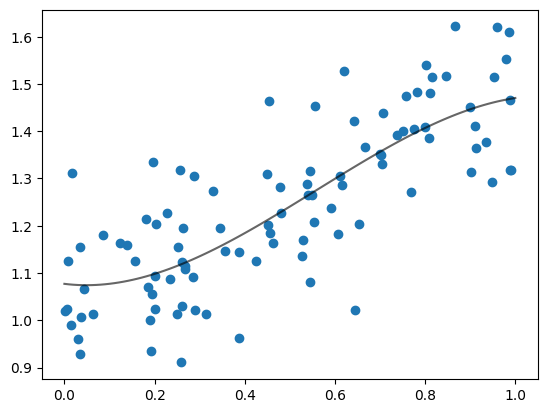

In [14]:
k = 4
p0 = jnp.zeros(k)
p_hat = grad_descent(loss, data, p0)
print('Estimated parameter vector:')
print(p_hat)
print('\n\n')

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x_grid, jnp.polyval(p_hat, x_grid), 'k-', alpha=0.6)
plt.show()